In [1]:
import numpy as np
import math
from scipy.stats import gamma
from sklearn.decomposition import IncrementalPCA

import tensorly as tl
from tensorly.cp_tensor import cp_mode_dot
import tensorly.tenalg as tnl
from tensorly.tenalg.core_tenalg import tensor_dot, batched_tensor_dot, outer, inner

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pca import PCA

# Import TensorLy
import tensorly as tl
from tensorly.tenalg import kronecker
from tensorly import norm
from tensorly.decomposition import symmetric_parafac_power_iteration as sym_parafac
from tensorly.tenalg.core_tenalg.tensor_product import batched_tensor_dot
from tensorly.testing import assert_array_equal, assert_array_almost_equal

from tensorly.contrib.sparse.cp_tensor import cp_to_tensor

from tlda_final import TLDA
import cumulant_gradient
import tensor_lda_util as tl_util
## Break down into steps, then re-engineer.

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        to_return = [porter.stem(self.wnl.lemmatize(t,get_wordnet_pos(t))) for t in word_tokenize(articles)]
        return to_return
    
class StemTokenizer(object):
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, articles):
        return [self.porter.stem(t) for t in word_tokenize(articles)]

from helpers import gtp 

        
import gc
from datetime import datetime
import random

import scipy

[nltk_data] Downloading package punkt to /home/adrien/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adrien/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/adrien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
!echo $PWD

/home/adrien/twitter-analysis/old/TensorJST_Public


In [6]:
# load tweets

import os
from helpers import load_tweets
filenames = ['../../data/unzipped/' + name for name in os.listdir('../../data/unzipped')]

all_tweets = load_tweets(filenames, preprocessor=None)

In [7]:
len(all_tweets)

331755

In [8]:
# use only 100000 tweets
tweets = random.sample(all_tweets, 100000)

In [9]:
# def stop words
n_samples = len(tweets)
print(n_samples)



100000


In [17]:
gtp('#chinesevirus')

['chinesevirus']

In [28]:
vocab = list(np.load('../../bigVocabCountVec_id-word-map_2021-07-12.npy')) + gtp('#chinesevirus')


In [29]:
# countvec = CountVectorizer(tokenizer=gtp,
countvec = CountVectorizer(tokenizer=gtp,
                                strip_accents = 'unicode', # works
                                lowercase = True, # works
                                ngram_range = (1,2),
                                # max_df = 0.4, # works
                                # min_df = int(0.002*n_samples))
                                vocabulary=vocab)

dtm = countvec.fit_transform(tweets)

In [30]:
dtm_sent = scipy.sparse.csr_matrix(dtm)


In [31]:
a = tl.tensor(dtm_sent.toarray(),dtype=np.float16)


In [32]:
del dtm_sent
gc.collect()

10429

In [33]:
M1      = tl.mean(a, axis=0)


In [34]:
M1.shape

(1001,)

In [35]:
x_cent = scipy.sparse.csr_matrix(a - M1,dtype=np.float16) #center the data using the first moment 


In [36]:
gc.collect()


0

In [37]:

start = datetime.now()
print("now =", start)


batch_size = int(n_samples/20)
verbose = True
n_topic =  20

beta_0=0.003

pca = PCA(n_topic, beta_0, 30000)
pca.fit(x_cent) # fits PCA to  data, gives W
x_whit = pca.transform(x_cent) # produces a whitened words counts <W,x> for centered data x
now = datetime.now()
print("now =", now)
pca_time = now - start 

'''
for data in yield_data:
    pca.partial_fit(data)
'''

now = 2021-07-12 17:58:06.839960
now = 2021-07-12 17:58:34.728216


'\nfor data in yield_data:\n    pca.partial_fit(data)\n'

In [38]:
gc.collect()
print(pca_time)

0:00:27.888256


In [39]:
from importlib import reload  
import tlda_final
reload(tlda_final)
from tlda_final import TLDA


now = datetime.now()
print("now =", now)
learning_rate = 0.01 
batch_size =15000
t = TLDA(n_topic,n_senti=1, alpha_0= beta_0, n_iter_train=1000, n_iter_test=150, batch_size=batch_size,
         learning_rate=learning_rate)
now = datetime.now()
print("now =", now)

now = 2021-07-12 17:58:35.053658
now = 2021-07-12 17:58:35.056311


In [40]:
now = datetime.now()
print("now =", now)

t.fit(x_whit,verbose=True) # fit whitened wordcounts to get decomposition of M3 through SGD

now = datetime.now()
print("now =", now)

now = 2021-07-12 17:58:35.087977
Epoch: 200
Epoch: 400
Epoch: 600
Epoch: 800
now = 2021-07-12 17:58:58.259117


In [41]:
now = datetime.now()
print("now =", now)


factors = pca.reverse_transform(t.factors_)  # unwhiten the eigenvectors to get unscaled word-level factors
t.factors_ = factors
''' 
Recover alpha_hat from the eigenvalues of M3
'''  

eig_vals = [np.linalg.norm(k,3) for k in factors ]
# normalize beta
alpha      = np.power(eig_vals, -2)
print(alpha.shape)
alpha_norm = (alpha / alpha.sum()) * beta_0
t.alpha_   = alpha_norm
        
print(alpha_norm)

t.predict(x_whit,w_mat=True,doc_predict=False)  # normalize the factors 


now = datetime.now()
print("now =", now)

now = 2021-07-12 17:58:58.321296
(20,)
[1.21965117e-04 2.16296231e-04 9.24462428e-05 1.00529733e-04
 1.20209706e-04 2.32833776e-04 2.01127262e-04 1.13486933e-04
 1.36614986e-04 7.70022425e-05 1.39274383e-04 2.83587408e-04
 9.71779783e-05 2.12841560e-04 2.51512292e-04 7.77996945e-05
 9.28144477e-05 1.27570119e-04 2.29225037e-04 7.56848520e-05]
now = 2021-07-12 17:58:58.333220


In [42]:
id_map = np.array(countvec.get_feature_names())
np.save('id_map.npy', id_map)
np.save('factors.npy', factors)


In [43]:
import pickle
with open('trained_tlda.pickle', 'wb') as f:
    pickle.dump(t, f)

In [44]:
with open('trained_tlda.pickle', 'rb') as f:
    t = pickle.load(f)

In [45]:
t.factors_.shape

(20, 1001)

In [66]:
# top = id_map[factors[0,:].argsort()[-20:]]
top_words = factors[0,:].argsort()
'chinesevirus' in id_map[top_words]
np.where(id_map == 'chinesevirus')
id_map[-1]
stf = []
for i in range(n_topic):
    stf.append(factors[i,1000])

([<matplotlib.axis.XTick at 0x7f49f221ec40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

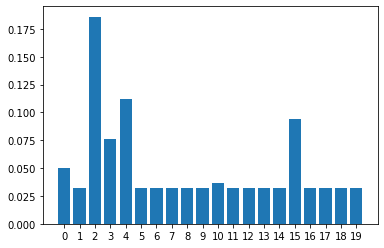

In [71]:
import matplotlib.pyplot as plt
plt.bar(range(n_topic), stf)
plt.xticks(ticks=range(20))

In [47]:
# top = factors[0,factors[0,:].argsort()[-20:]]

In [48]:
n_top_words=20
#print(t_n_indices)
n_sentiments = 1
top_words_JST = None
for k in range(n_topic*n_sentiments):
    if k ==0:
        t_n_indices   =factors[k,:].argsort()[:-n_top_words - 1:-1]
        top_words_JST = [i for i,v in countvec.vocabulary_.items() if v in t_n_indices]
    else:
        t_n_indices   =factors[k,:].argsort()[:-n_top_words - 1:-1]
        top_words_JST = np.vstack([top_words_JST, [i for i,v in countvec.vocabulary_.items() if v in t_n_indices]])
        # print([i for i,v in countvec.vocabulary_.items() if v in t_n_indices])

In [49]:
sorted(top) == sorted(top_words_JST[0])

True

In [50]:
top_words_JST

array([['activ', 'case', 'case coronavirus', 'case death', 'case http',
        'china', 'communist', 'confirm', 'confirm case',
        'coronavirus case', 'covid case', 'georgia', 'hell', 'hide',
        'know', 'probabl', 'record', 'total', 'true', 'truth'],
       ['bank', 'campaign', 'congress', 'cost', 'donat', 'econom',
        'financi', 'fund', 'help', 'leader', 'leadership', 'loan',
        'local', 'need', 'option', 'pelosi', 'prepar', 'student',
        'suppli', 'support'],
       ['agenc', 'author', 'canada', 'china', 'claim', 'counti', 'cover',
        'covid case', 'covid patient', 'critic', 'detail', 'inform',
        'investig', 'origin', 'outbreak', 'outbreak http', 'patient',
        'trade', 'travel', 'wuhan'],
       ['amid coronavirus', 'bring', 'close', 'coronavirus outbreak',
        'despit', 'drop', 'forc', 'live', 'live updat', 'offic',
        'offici', 'outbreak', 'past', 'plan', 'report', 'return', 'see',
        'warn', 'world', 'wuhan'],
       ['china'

In [51]:
now = datetime.now()



print("now =", now)
print(t.factors_.shape)
a_word       = tl.tensor(dtm.toarray(),dtype=tl.float32)

doc_topic_dist, topic_word_dist = t.predict(a_word,w_mat=False,doc_predict=True)
now = datetime.now()
 
print("now =", now)
end = datetime.now()
print(end)

now = 2021-07-12 17:58:58.789043
(20, 1001)


KeyboardInterrupt: 